# Prepare Project

Can be run on Google Colab.

## Install libraries

In [ ]:
!pip install -r requirements.txt

## Import libraries

In [1]:
import os
import cv2
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

sns.set()

import GPyOpt
import tensorflow as tf
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Input, InputLayer, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose

## Helper functions

### Data Processing functions

General Image pre-processing/augmentation

In [2]:
# Define download function

def download(url, destination_folder='.'):
  '''
  Downloads data from a URL to a specified folder.
  '''

  !wget -nc -q --show-progress $url -P $destination_folder


# Define preprocessing functions

def draw_hair(image, num_hair=7, hair_width=(1, 2)):
  '''
  Draws random lines to mimic fake hair on the skin.
  '''

  width, height, _ = image.shape
  image_hair = image.copy()

  for _ in range(random.randint(0, num_hair)):

    # The origin point of the line will always be at the top half of the image
    origin = (random.randint(0, width), random.randint(0, height // 2))

    # The end of the line
    end = (random.randint(0, width), random.randint(0, height))

    # Color of the hair: black
    color = (0, 0, 0)
    cv2.line(image_hair, origin, end, color, random.randint(hair_width[0], hair_width[1]))

  return image_hair


def dermoscope(image, p=0.5):
  '''
  Cuts out the edges around the center circle of the image to
  imitate a picture, taken through a dermoscope.
  '''

  if random.random() < p:
      circle = cv2.circle((np.ones(image.shape) * 255).astype(np.uint8), # image placeholder
                  (image.shape[0]//2, image.shape[1]//2), # center point of circle
                  random.randint(image.shape[0]//2 - 3, image.shape[0]//2 + 15), # radius
                  (0, 0, 0), # color
                  -1)

      mask = circle - 255
      image = np.multiply(image, mask)

  return image


def custom_preprocessing_function(image):
  '''
  Combines the appropriate preprocessing function with custom ones.
  '''

  image_processed = image.copy()

  if preprocessing_function:
    image_processed = preprocessing_function(image_processed)

  image_processed = draw_hair(image_processed)
  image_processed = dermoscope(image_processed)

  return image_processed

Image Augmentation using GAN

In [3]:
class GAN(Model):
    '''
    GAN implementation for a given generator/discriminator pair.
    '''


    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


class GANMonitor(Callback):
    '''
    Custom callback to generate 3 images per epoch.
    '''

    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(results_directory + "/generated_img_%03d_%d.png" % (epoch, i))

### Visualization functions

In [4]:
def show_diagnosis(dataset, id='image', random_state=None,
                   training_path='/content/data/ISIC2018_Task3_Training_Input/'):
  '''
  Plots examples of each diagnosis in the training dataset.
  '''

  # Set random seed for reproducible results
  random.seed(random_state)

  # Create figure
  fig = plt.figure(figsize=(12, 7))
  plt.title('Diagnostic Examples', fontsize=13)
  plt.grid()
  plt.axis(False)
  columns = 4
  rows = 2
  ax = []

  # Diagnosis
  diagnosis = dataset.drop(id, axis=1).columns

  # Iterate for every diagnosis
  for index, col in enumerate(diagnosis):
    dataset_diagnosis = dataset.loc[dataset[col] == 1, id].values
    idx = random.choice(dataset_diagnosis)
    label = col

    # Read image
    img = plt.imread(training_path + idx + '.jpg')

    # Create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, index+1))

    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(label)
    plt.imshow(img)

  # Add one more example
  col = random.choice(diagnosis)
  dataset_diagnosis = dataset.loc[dataset[col] == 1, id].values
  idx = random.choice(dataset_diagnosis)
  label = col

  # Read image
  img = plt.imread(training_path + idx + '.jpg')

  # Create subplot and append to ax
  ax.append(fig.add_subplot(rows, columns, 8))

  # Hide grid lines
  ax[-1].grid(False)

  # Hide axes ticks
  ax[-1].set_xticks([])
  ax[-1].set_yticks([])
  ax[-1].set_title(label)
  plt.imshow(img)

  plt.show()


def show_transformations(dataset, id='image', random_state=None,
                   training_path='/content/data/ISIC2018_Task3_Training_Input/'):
  '''
  Plots examples of transformations applied in the training dataset.
  '''

  # Set random seed for reproducible results
  random.seed(random_state)

  # Create figure
  fig = plt.figure(figsize=(12, 7))
  plt.suptitle('Transformation Examples', fontsize=13)
  plt.grid()
  plt.axis(False)
  columns = 2
  rows = 2
  ax = []

  # Select a random image from the training set
  idx = random.choice(dataset[id])

  # Read image
  img = plt.imread(training_path + idx + '.jpg')

  # Plot original image and each transformation
  for index in range(0, 4):

    if index == 0:
      img_new = img.copy()
      label = 'Original Image'

    elif index == 1:
      img_new = draw_hair(img)
      label = 'Image with random fake hair'

    elif index == 2:
      img_new = dermoscope(img, p=1)
      label = 'Image seen from a dermoscope'

    elif index == 3:
      img_new = custom_preprocessing_function(img)
      label = 'Preprocessed Image'

    # Create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, index+1))

    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(label)
    plt.imshow(img_new)


def plot_model_history(model_history, save=True):
  '''
  Plot model's validation loss and validation accuracy.
  '''

  fig, axs = plt.subplots(1,2,figsize=(16, 7))

  # summarize history for accuracy
  axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
  axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
  axs[0].legend(['Training', 'Validation'], loc='best')

  # summarize history for loss
  axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylim(0, 3)
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
  axs[1].legend(['Training', 'Validation'], loc='best')

  if save == True:
      plt.savefig('Training history.png')

  plt.show()


def multiclass_roc_auc_score(y_test, y_pred, classes, average="macro"):
  '''
  Calculates and plots ROC curve for each class.
  '''

  # Calculate AUC
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)

  print(f'Average AUC = {roc_auc_score(y_test, y_pred, average=average):.2f}')

  # Plot results
  plt.figure(figsize=(16, 9))
  plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)

  for (idx, c_label) in enumerate(classes):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      plt.plot(fpr, tpr, label = '%s (AUC= %0.2f)'  % (c_label, auc(fpr, tpr)))

  # Plot random guessing
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("False Positive Rate", fontsize=14)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=14)

  plt.legend(prop={'size': 13}, loc='lower right')

  plt.show()

### Training functions

In [5]:
def conv_net(input_height, input_width, n_channels=3, n_filters=64,
             batchnorm=True, flatten=False, num_classes=7):
  '''
  Defines a small ConvNet model to be trained from scratch.
  '''

  inputs = Input(shape=(input_height, input_width, n_channels))

  # 1st Conv-Conv-Pool
  x = Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(inputs)
  x = Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(x)
  x = MaxPooling2D(pool_size=2)(x)

  if batchnorm:
    x = BatchNormalization()(x)

  # 2nd Conv-Conv-Pool
  x = Conv2D(filters=n_filters*2, kernel_size=3, activation="relu", padding="same")(x)
  x = Conv2D(filters=n_filters*2, kernel_size=3, activation="relu", padding="same")(x)
  x = MaxPooling2D(pool_size=2)(x)

  if batchnorm:
    x = BatchNormalization()(x)

  # Dense layers
  if flatten == True:
    x = Flatten()(x)
  else:
    x = GlobalAveragePooling2D()(x)

  x = Dense(256, activation="relu")(x)

  if num_classes == 2:
    units = 1
    activation = "sigmoid"
  else:
    units = num_classes
    activation = "softmax"

  outputs = Dense(units, activation=activation)(x)

  model = Model(inputs, outputs)

  return model


def print_model_menu():
  '''
  Prints selection menu to define base model and settings for training.
  '''

  # Print main menu
  print("\nSelect a pre-trained model from the list or train a model from scratch.")
  print("\n\t1) Train a model from scratch")
  print("\t2) DenseNet201")
  print("\t3) ResNet50")
  print("\t4) InceptionV3")
  print("\t5) EfficientNetB3")
  print("\t6) InceptionResNetV2")
  print("\t7) NASNet")

  selection = int(input())

  if selection == 1:
    img_size = 256
    base_model = 'ConvNet'
  elif selection == 2:
    img_size = 224
    base_model = 'DenseNet201'
  elif selection == 3:
    img_size = 224
    base_model = 'ResNet50'
  elif selection == 4:
    img_size = 299
    base_model = 'InceptionV3'
  elif selection == 5:
    img_size = 224
    base_model = 'EfficientNetB3'
  elif selection == 6:
    img_size = 299
    base_model = 'InceptionResNetV2'
  elif selection == 7:
    img_size = 331
    base_model = 'NASNet'
  else:
    raise ValueError('Invalid option. Select a number from 1 to 7.')


  print("\nChoose a batch size for training.")

  batch_size = int(input())

  return base_model, img_size, batch_size


def cnn_function(params):
  '''
  Function to be minimized for Bayesian Optimization.
  '''

  list_validation_loss = []
  list_saved_model_name = []
  list_early_stop_epochs = []
  model_name = 'ConvNet-{epoch:02d}-{weighted_accuracy:.3f}-{val_weighted_accuracy:.3f}' + '_' + str(np.random.uniform(0,1))[2:9]

  optimizer_dict = {1:'SGD', 2:'RMSprop', 3:'Adam', 4:'Nadam'}
  dict_params = {'num_cnn_blocks':int(params[0][0]),
                 'num_filters':int(params[0][1]),
                 'kernel_size':int(params[0][2]),
                 'num_dense_nodes':int(params[0][3]),
                 'dense_nodes_divisor':int(params[0][4]),
                 'drop_out':params[0][5],
                 'optimizer':params[0][6]}

  # Model structure
  inputs = Input(shape=(256, 256, 3))

  # 1st Conv-Conv-Pool
  x = Conv2D(filters=dict_params['num_filters'],
             kernel_size=dict_params['kernel_size'],
             strides=1, activation='relu', padding='same')(inputs)
  x = Conv2D(filters=dict_params['num_filters'],
             kernel_size=dict_params['kernel_size'],
             strides=1, activation="relu", padding='same')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = BatchNormalization()(x)

  # Nth Conv-Conv-Pool
  for iblock in range(dict_params['num_cnn_blocks'] - 1):
    x = Conv2D(filters=dict_params['num_filters'],
               kernel_size=dict_params['kernel_size'],
               strides=1, activation="relu", padding='same')(x)
    x = Conv2D(filters=dict_params['num_filters'],
               kernel_size=dict_params['kernel_size'],
               strides=1, activation="relu", padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

  # Dense layers
  x = GlobalAveragePooling2D()(x)
  x = Dense(dict_params['num_dense_nodes'], activation='relu')(x)
  x = Dropout(dict_params['drop_out'])(x)
  x = Dense(dict_params['num_dense_nodes']//dict_params['dense_nodes_divisor'], 
            activation='relu')(x)
  outputs = Dense(7, activation='softmax')(x)

  cnn_model = Model(inputs=inputs, outputs=outputs)

  # Optimizers
  opt = optimizer_dict[dict_params['optimizer']]
  cnn_model.compile(loss='categorical_crossentropy', optimizer=opt,
                    metrics=['accuracy', 'AUC'], weighted_metrics=['accuracy'])

  # Callbacks
  results_dir = '/content/'
  custom_weights = {0: 1.5, 1: 2.0, 2: 1.0, 3: 10.0, 4: 3.0, 5: 0.4, 6: 10.0}

  callbacks_list = [EarlyStopping(monitor='val_loss', patience=10),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                                      verbose=0, mode='auto', min_lr=1.0e-6),
                    ModelCheckpoint(filepath=results_dir + model_name + '.h5', mode='max',
                                    monitor='val_weighted_accuracy', save_best_only=True)]

  h = cnn_model.fit(train_batches, validation_data=valid_batches,
                    epochs=10, callbacks=callbacks_list, shuffle=True,
                    verbose=1, class_weight=custom_weights)

  # Record actual best epochs and valid loss here, added to bayes opt parameter df below
  validation_loss = np.min(h.history['val_loss'])

  list_early_stop_epochs.append(len(h.history['val_loss']) - 15)
  list_validation_loss.append(validation_loss)
  list_saved_model_name.append(model_name)

  return validation_loss

# Main Project

## Download data

### Training data

Downloading all training data may take a while.

ISIC 2018 Dataset (HAM10000)

In [ ]:
# Prepare directory to download data
phases = ['Training', 'Validation', 'Test']
data_root = os.path.join(os.getcwd(), 'data')
data_dir = {phase:os.path.join(data_root, phase) for phase in phases}

# Download Training.zip, Validation.zip, Test.zip and ground truth labels
for phase in phases:
  download(f'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_{phase}_Input.zip', data_root)

for phase in phases[:2]:
  download(f'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_{phase}_GroundTruth.zip', data_root)

In [ ]:
# Unzip Training.zip, Validation.zip, Test.zip and ground truth labels
for phase in phases:
  if not os.path.exists(data_dir[phase]):
    with zipfile.ZipFile(os.path.join(data_root, f'ISIC2018_Task3_{phase}_Input.zip'), 'r') as myzip:
      for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
        myzip.extract(member=file, path=data_root)

for phase in phases[:2]:
  if not os.path.exists(data_dir[phase]):
    with zipfile.ZipFile(os.path.join(data_root, f'ISIC2018_Task3_{phase}_GroundTruth.zip'), 'r') as myzip:
      for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
        myzip.extract(member=file, path=data_root)

Download additional data: BCN20000 (Dermoscopic Images)

In [ ]:
# Download BCN20000 dataset
!sla-cli download -c bcn_20000

In [9]:
df = pd.read_csv('/content/bcn_20000/metadata.csv')

diagn_map = {'melanoma': 'MEL', 'basal cell carcinoma': 'BCC', 'seborrheic keratosis': 'BKL',
             'actinic keratosis': 'AKIEC', 'solar lentigo': 'BKL', 'dermatofibroma': 'DF',
             'vascular lesion': 'VASC'}

df['dx'] = df['dx'].map(diagn_map)
df = df.dropna(subset=['dx'], axis=0).reset_index(drop=True)
bcn_data = df[['image_name', 'dx']].copy()

In [10]:
bcn_dir = '/content/bcn_20000/images'
train_dir = '/content/data/ISIC2018_Task3_Training_Input'

file_names = os.listdir(bcn_dir)

for file_name in file_names:
    shutil.move(os.path.join(bcn_dir, file_name), train_dir)

PAD-UFES-20 (Camera Images)

In [ ]:
# Download PAD-UFES-20 dataset. Error in cleaning up doesn't affect the images
!sla-cli download -c pad_ufes_20

In [12]:
df2 = pd.read_csv('/content/PAD_UFES_20/metadata.csv')

diagn_map2 = {'BCC': 'BCC', 'ACK': 'AKIEC', 'SEK': 'BKL', 'MEL': 'MEL'}

df2['diagnostic'] = df2['diagnostic'].map(diagn_map2)
df2 = df2.dropna(subset=['diagnostic'], axis=0).reset_index(drop=True)
pad_data = df2[['img_id', 'diagnostic']]

In [13]:
pad_dir = '/content/PAD_UFES_20/images'
train_dir = '/content/data/ISIC2018_Task3_Training_Input'
    
file_names = os.listdir(pad_dir)

for file_name in file_names:
    shutil.move(os.path.join(pad_dir, file_name), train_dir)

### Testing data under different evaluation scenarios

UDA1: Dermoscopic Images for Melanoma vs Nevi classification

In [ ]:
# Download UDA1 dataset
!sla-cli download -c uda_1

In [15]:
# Create dataframe with labels
uda_1_labels = pd.read_csv('/content/uda_1/metadata.csv')

dx_map = {'nevus': 'NV', 'melanoma': 'MEL'}

uda_1_labels['image_name'] = uda_1_labels['image_name'] + '.jpg'
uda_1_labels['dx'] = uda_1_labels['dx'].map(dx_map)
uda_1_labels = uda_1_labels.dropna(subset=['dx'], axis=0).reset_index(drop=True)
uda_1_labels = uda_1_labels[['image_name', 'dx']]

MEDNODE: Camera Images for Melanoma vs Nevi classification

In [ ]:
# Download MEDNODE dataset
!sla-cli download -c mednode

In [17]:
# Create dataframe with labels
mednode_labels = pd.read_csv('/content/mednode/metadata.csv')
dx_map = {'nevus': 'NV', 'melanoma': 'MEL'}

mednode_labels['image_name'] = mednode_labels['image_name'] + '.jpg'
mednode_labels['dx'] = mednode_labels['dx'].map(dx_map)
mednode_labels = mednode_labels.dropna(subset=['dx'], axis=0).reset_index(drop=True)
mednode_labels = mednode_labels[['image_name', 'dx']]

## Load and explore data

In [18]:
# Reading the datasets
data_root = os.path.join(os.getcwd(), 'data')
train_labels = pd.read_csv(os.path.join(data_root, 'ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'))
val_labels = pd.read_csv(os.path.join(data_root, 'ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'))

validation_labels = val_labels.copy()
validation_labels['diagnosis'] = validation_labels.iloc[:, 1:].idxmax(axis=1)
validation_labels['img_id'] = validation_labels['image'] + '.jpg'
val_data = validation_labels[['img_id', 'diagnosis']]

In [19]:
# Integrate all data
training_labels = train_labels.copy()
training_labels['diagnosis'] = training_labels.iloc[:, 1:].idxmax(axis=1)
training_labels['img_id'] = training_labels['image'] + '.jpg'
train_data = training_labels[['img_id', 'diagnosis']]

bcn_data['img_id'] =  bcn_data['image_name'] + '.jpg'
bcn_data = bcn_data[['img_id', 'dx']]
bcn_data = bcn_data.rename(columns={'dx':'diagnosis'})

pad_data = pad_data.rename(columns={'diagnostic':'diagnosis'})

# Create merged dataset
train_all = pd.concat([train_data, bcn_data, pad_data], axis=0).reset_index(drop=True)

Check for null values



In [ ]:
train_labels.isnull().sum()

In [ ]:
train_all.describe()

## Data Visualisation

Show class distribution before and after integrating additional data

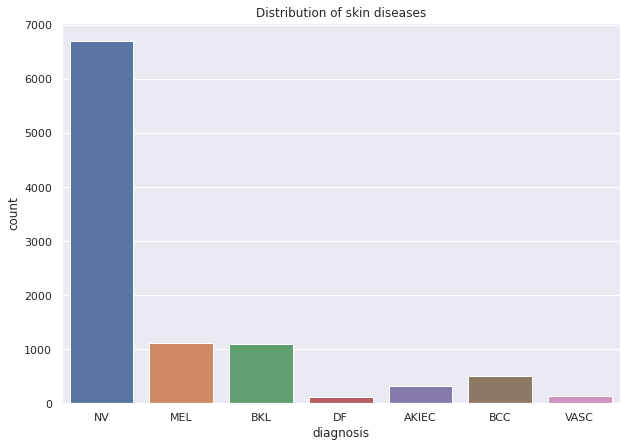

In [22]:
# Count the number of diagnoses
plt.figure(figsize=(10, 7))

plt.title('Distribution of skin diseases')
sns.countplot(data=train_data, x='diagnosis')

plt.show()

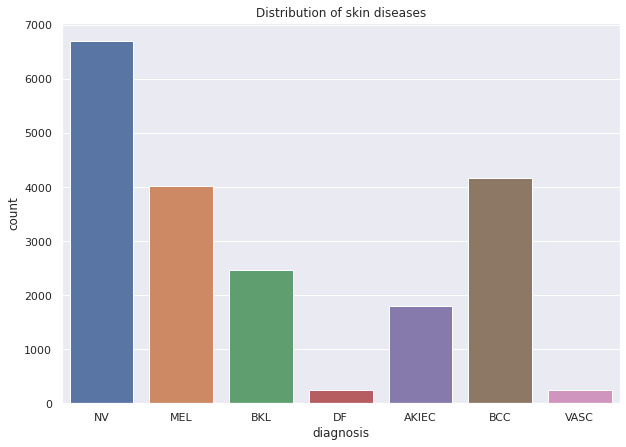

In [23]:
# Count the number of diagnoses
plt.figure(figsize=(10, 7))

plt.title('Distribution of skin diseases')
sns.countplot(data=train_all, x='diagnosis')

plt.show()

Compare percentages

In [24]:
# Show percentages
print(f"Initial percentage of each diagnosis:\n{100*train_data['diagnosis'].value_counts(normalize=True).to_frame()}")

# Show percentages
print(f"\nFinal percentage of each diagnosis:\n{100*train_all['diagnosis'].value_counts(normalize=True).to_frame()}")

Initial percentage of each diagnosis:
       diagnosis
NV     66.949576
MEL    11.113330
BKL    10.973540
BCC     5.132302
AKIEC   3.265102
VASC    1.417873
DF      1.148278

Final percentage of each diagnosis:
       diagnosis
NV     34.116929
BCC    21.207958
MEL    20.465069
BKL    12.578232
AKIEC   9.128377
VASC    1.287335
DF      1.216099


We observe that the dataset is now more balanced, but the DF and VASC class are still too low. 

Thus, we use a weighted loss function to capture that. 

We also tried using a GAN to generate more images and boost these two classes, but with no improvement.

## Diagnosis Visualisation

Plot some diagnostic examples.

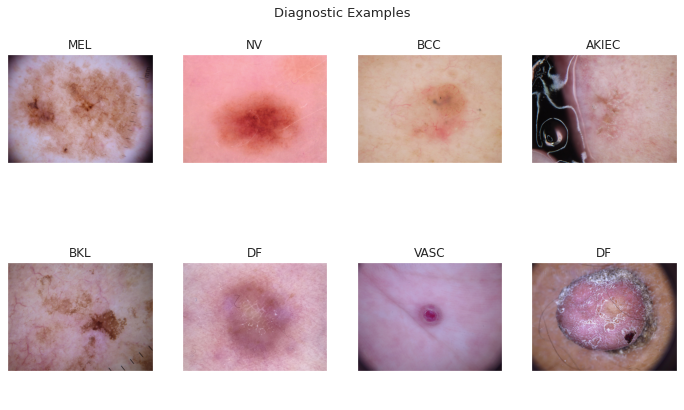

In [25]:
show_diagnosis(train_labels, random_state=42)

## Model Definition

In [ ]:
# Define model and settings for training
base_model, img_size, batch_size = print_model_menu()

if base_model == 'ConvNet':
  model = conv_net(input_height=img_size, input_width=img_size)
elif base_model == 'DenseNet201':
  from tensorflow.keras.applications.densenet import DenseNet201 as PTModel, preprocess_input
elif base_model == 'ResNet50':
  from tensorflow.keras.applications.resnet import ResNet50 as PTModel, preprocess_input
elif base_model == 'InceptionV3':
  from tensorflow.keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif base_model == 'EfficientNetB3':
  from tensorflow.keras.applications.efficientnet import EfficientNetB3 as PTModel, preprocess_input
elif base_model == 'InceptionResNetV2':
  from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel, preprocess_input
elif base_model == 'NASNet':
  from tensorflow.keras.applications.nasnet import NASNetLarge as PTModel, preprocess_input
else:
  raise ValueError('Unknown model: {}'.format(base_model))

# Select the appropriate preprocessing function, if applicable
try:
  preprocessing_function = preprocess_input
except:
  preprocessing_function = None

In [27]:
# Show selected options
print(f'Model: {base_model}, Image size: {img_size}, Batch size: {batch_size}')

Model: EfficientNetB3, Image size: 224, Batch size: 128


## Image Augmentation

Implement data augmentation using Keras Image Generator and custom processing functions.

We created two chained transformations: 
 - one for testing with images resized to the required size and normalized,
 - one for training with some data augmentation: 
     - __random image rotation__ with a maximum of 20 degrees, 
     - __random width/height shift__ with maximum fraction equal to 0.1,
     - __random zoom__ with a 0.8-1.2 scale,
     - __random shear__ with shear intensity equal to 0.2,
     - __random horizontal/vertical flip__.

In addition, dermoscopic images sometimes include hairs.
Thus, we also created and added a __custom augmenter to draw random fake hairs__ and an __augmenter to mimic images shown from a dermoscope__.

Let's plot an example of these transformations.

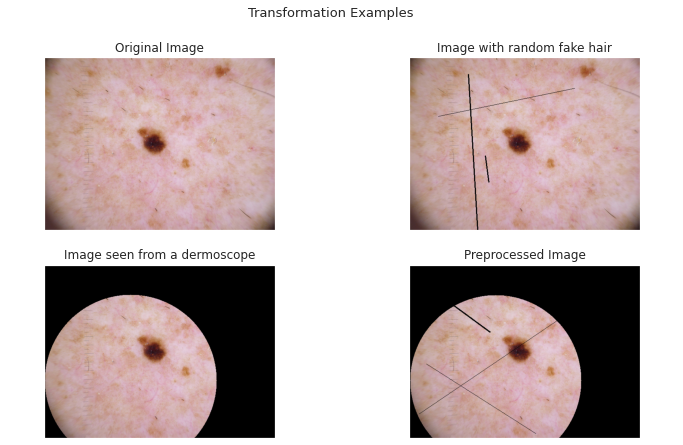

In [28]:
show_transformations(train_labels, random_state=55)

Train/Test Image Generator

In [29]:
# Load data in batches with an ImageDataGenerator

datagen_train = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    brightness_range=None,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.0,
                    fill_mode='nearest',
                    cval=0.0,
                    horizontal_flip=True,
                    vertical_flip=True,
                    rescale=1.0/255.0,
                    preprocessing_function=custom_preprocessing_function,
                    validation_split=0.2)

datagen_test = ImageDataGenerator(
                    rescale=1.0/255.0,
                    preprocessing_function=preprocessing_function)

Train/Validation/Test directories

In [30]:
# Training Generators
train_batches = datagen_train.flow_from_dataframe(dataframe=train_all, directory=os.path.join(data_root, 'ISIC2018_Task3_Training_Input'),
                                                  x_col='img_id', y_col='diagnosis', class_mode='categorical', batch_size=batch_size, shuffle=True,
                                                  target_size= (img_size, img_size), subset='training')

valid_batches = datagen_train.flow_from_dataframe(dataframe=train_all, directory=os.path.join(data_root, 'ISIC2018_Task3_Training_Input'),
                                                  x_col='img_id', y_col='diagnosis', class_mode='categorical', batch_size=batch_size, shuffle=True,
                                                  target_size= (img_size, img_size), subset='validation')

Found 15723 validated image filenames belonging to 7 classes.
Found 3930 validated image filenames belonging to 7 classes.


In [31]:
# Evaluation Generators
test_batches = datagen_test.flow_from_directory(data_root, batch_size=batch_size,
                                                target_size=(img_size, img_size), shuffle=False, classes = ['ISIC2018_Task3_Test_Input'])

valid_ind_batches = datagen_test.flow_from_dataframe(dataframe=val_data, directory=os.path.join(data_root, 'ISIC2018_Task3_Validation_Input'),
                                             x_col='img_id', y_col='diagnosis', class_mode='categorical', batch_size=batch_size,
                                             shuffle=False, target_size= (img_size, img_size))

Found 1512 images belonging to 1 classes.
Found 193 validated image filenames belonging to 7 classes.


In [33]:
# Testing generators
uda_batches = datagen_test.flow_from_dataframe(dataframe=uda_1_labels, directory='/content/uda_1/images', x_col='image_name', y_col='dx',
                                               class_mode='categorical', batch_size=batch_size, shuffle=False, target_size=(img_size, img_size))

mednode_batches = datagen_test.flow_from_dataframe(dataframe=mednode_labels, directory='/content/mednode/images', x_col='image_name', y_col='dx',
                                                   class_mode='categorical', batch_size=batch_size, shuffle=False, target_size=(img_size, img_size))

Found 555 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.


## Model Training

### Train model from scratch to serve as a baseline classifier

In [ ]:
# Model summary
model.summary()

# Compile model
optimizer=optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'AUC'], weighted_metrics=['accuracy'])

### Fine-tuning of pre-trained model

In [ ]:
# Define final model
base_pretrained_model = PTModel(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_pretrained_model.trainable = False

model = base_pretrained_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(256, activation='relu')(model)
model = Dropout(0.2)(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.1)(model)
predictions = Dense(7, activation='softmax')(model)

model = Model(inputs=base_pretrained_model.input, outputs=predictions)

# Model summary
model.summary()

# Compile model
optimizer=optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'AUC'], weighted_metrics=['accuracy'])

### Callbacks and loss function

 Callbacks

 - Early stopping
 - Reduce learning rate on plateau
 - Checkpoint to save the model with its accuracy after each epoch 

In [ ]:
# Callback functions
filepath = '/content/EfficientNet-{epoch:02d}-{weighted_accuracy:.3f}-{val_weighted_accuracy:.3f}.h5'


# Early stopping
earlystop_callback = EarlyStopping(monitor='val_loss', patience=10,
                                   verbose=1, restore_best_weights = True)

# ReduceLR
reducelr_callback = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1,
                                      verbose=1, restore_best_weights = True)

# Save the model's weights
checkpoint_callback = ModelCheckpoint(filepath=filepath, verbose=1,
                                      save_weights_only=True, mode='max',
                                      monitor='val_weighted_accuracy')

my_callbacks = [earlystop_callback, reducelr_callback, checkpoint_callback]

Create custom weights to reflect class imbalance and disease severity

In [ ]:
# Weighted loss
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_all['diagnosis']),
                                                 train_all['diagnosis'])
class_weights = dict(enumerate(class_weights))

print(np.unique(train_all['diagnosis']))
print(class_weights)

# Observe balanced weights and edit for disease severity
custom_weights = {0: 1.5, 1: 0.6, 2: 1.0, 3: 10.0, 4: 3.0, 5: 0.4, 6: 10.0}

### Start training

Train for 2 epochs with base model frozen and then update all weights.

In [ ]:
h = model.fit(train_batches, validation_data=valid_batches, callbacks=my_callbacks,
              epochs=2, shuffle=True, verbose=1, class_weight=custom_weights,
              steps_per_epoch=15723//batch_size, validation_steps=3930//batch_size)

In [ ]:
for layer in model.layers:
  layer.trainable = True

model.summary()

optimizer=optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'AUC'], weighted_metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_batches, validation_data=valid_batches, callbacks=my_callbacks,
                    epochs=30, shuffle=True, verbose=1, class_weight=custom_weights,
                    steps_per_epoch=15723//batch_size, validation_steps=3930//batch_size)

In [ ]:
# Plot training history
plot_model_history(history)

## Model Evaluation

Use the recently trained model or load the weights from the models we have trained.

In [ ]:
# Download the best models' weights 

# EfficientNet-B3
!gdown 'https://drive.google.com/uc?id=1lebK-70tcon9hUWjfTm-sqsjqH2Ny83f'

# Inception-v3
!gdown 'https://drive.google.com/uc?id=1wmNirs6NwvLEamvGSwLzRlJHLwHivPit'

# Load model's weights
model.load_weights('/content/EfficientNetB3.h5')

### Independent validation dataset (193 Images)

Obtain and evaluate predictions

In [36]:
# Evaluate the model on the validation dataset

results = model.evaluate(valid_ind_batches, verbose=0)
print("Test loss: {:.3f}".format(results[0]))
print("Test accuracy: {:.3f}".format(results[1]))

Test loss: 0.554
Test accuracy: 0.834


Plot confusion matrix and classification report

Classification Report

              precision    recall  f1-score   support

       AKIEC       0.38      0.38      0.38         8
         BCC       1.00      0.87      0.93        15
         BKL       0.62      0.68      0.65        22
          DF       0.50      1.00      0.67         1
         MEL       0.55      0.81      0.65        21
          NV       0.97      0.89      0.93       123
        VASC       1.00      1.00      1.00         3

    accuracy                           0.83       193
   macro avg       0.72      0.80      0.74       193
weighted avg       0.86      0.83      0.84       193



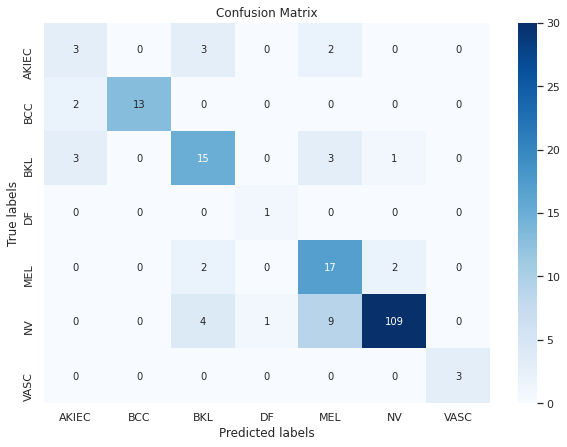

In [37]:
valid_ind_batches.reset() # resetting generator
Y_pred = model.predict(valid_ind_batches)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report\n')
target_names = list(valid_ind_batches.class_indices.keys())
print(classification_report(valid_ind_batches.classes, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(valid_ind_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# Plot confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, vmin=0, vmax=30, fmt='g', cmap='Blues')

# labels, title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Plot ROC curve

Average AUC = 0.89


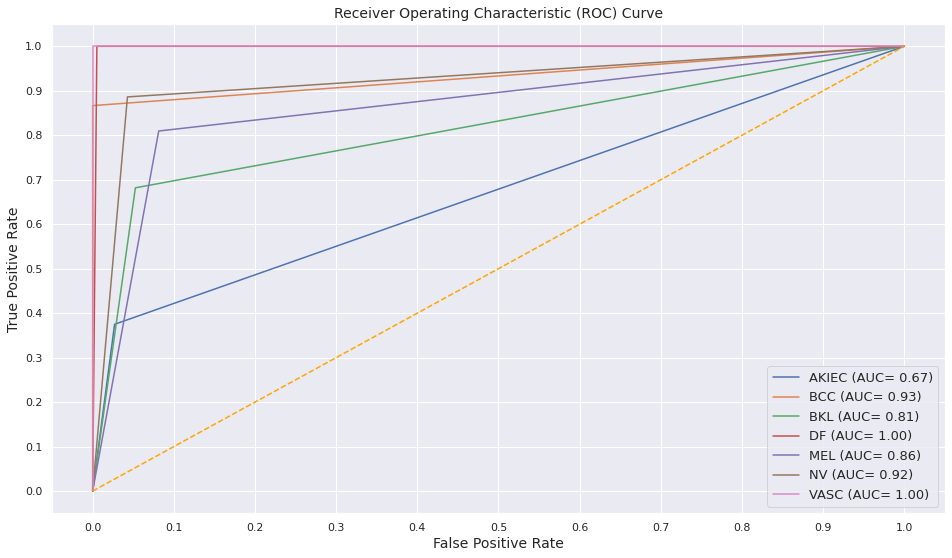

In [38]:
# Call function to plot ROC curve
multiclass_roc_auc_score(valid_ind_batches.classes, y_pred, target_names)

### Evaluation under different testing scenarios

UDA1: Dermoscopic Images for Melanoma vs Nevi classification (555 images)

Classification Report

              precision    recall  f1-score   support

         MEL       0.50      0.77      0.61       159
          NV       0.88      0.69      0.77       396

    accuracy                           0.71       555
   macro avg       0.69      0.73      0.69       555
weighted avg       0.77      0.71      0.73       555



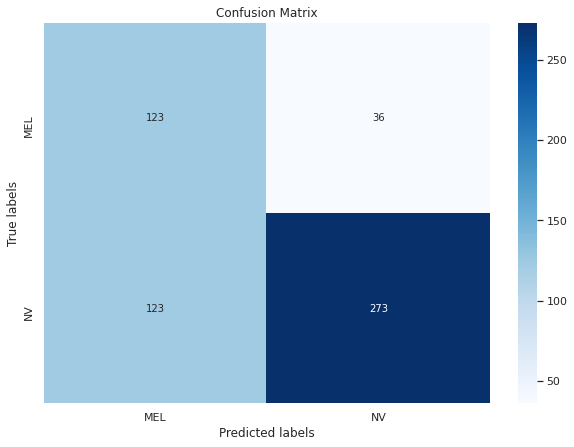

In [39]:
uda_batches.reset() # resetting generator
Y_pred = model.predict(uda_batches)
y_pred = np.argmax(Y_pred[:, 4:6], axis=1)

print('Classification Report\n')
target_names = list(uda_batches.class_indices.keys())
print(classification_report(uda_batches.classes, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(uda_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# Plot confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

# labels, title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Average AUC = 0.73


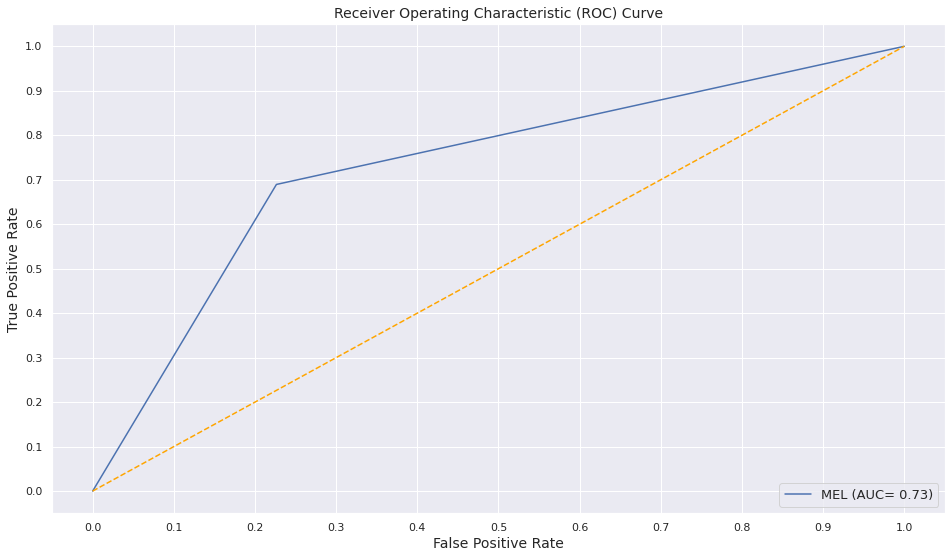

In [40]:
# Call function to plot ROC curve
multiclass_roc_auc_score(uda_batches.classes, y_pred, target_names[:1])

MEDNODE: Camera Images for Melanoma vs Nevi classification (170 Images)

Classification Report

              precision    recall  f1-score   support

         MEL       0.50      0.96      0.66        70
          NV       0.92      0.34      0.50       100

    accuracy                           0.59       170
   macro avg       0.71      0.65      0.58       170
weighted avg       0.75      0.59      0.56       170



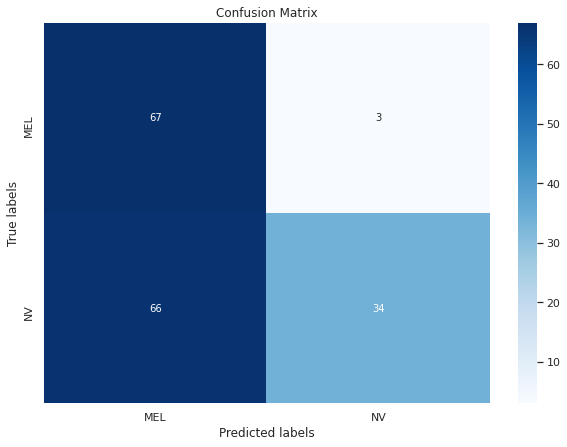

In [41]:
mednode_batches.reset() # resetting generator
Y_pred = model.predict(mednode_batches)
y_pred = np.argmax(Y_pred[:, 4:6], axis=1)

print('Classification Report\n')
target_names = list(mednode_batches.class_indices.keys())
print(classification_report(mednode_batches.classes, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(mednode_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# Plot confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

# labels, title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Average AUC = 0.65


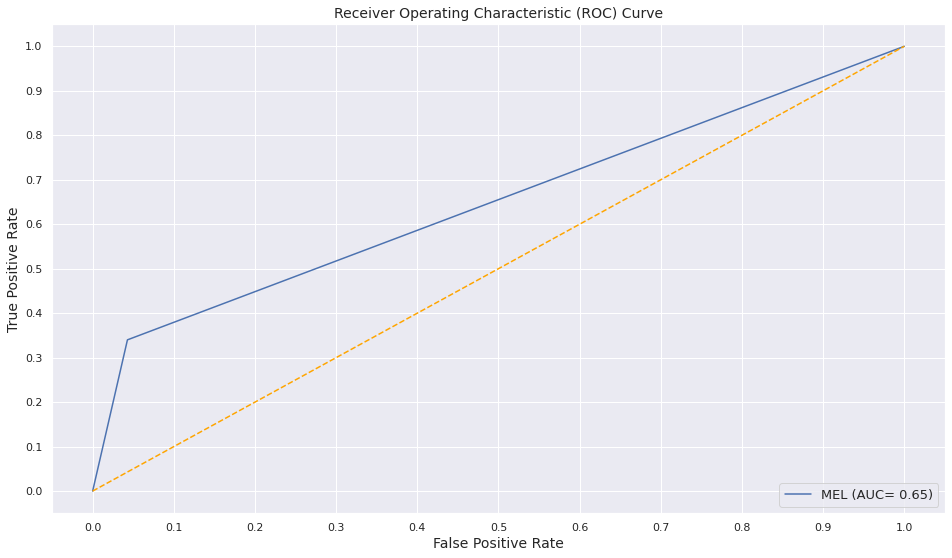

In [42]:
# Call function to plot ROC curve
multiclass_roc_auc_score(mednode_batches.classes, y_pred, target_names[:1])

### Evaluation on test set for public leaderboard (1512 Images)

In [43]:
# Get predictions on the test dataset
test_batches.reset()
results = model.predict(test_batches)

# Transform predictions on the appropriate format for submission
df_pred = pd.DataFrame(results)
df_pred = df_pred.rename(columns={0:'AKIEC', 1:'BCC', 2:'BKL', 3:'DF', 4:'MEL', 5:'NV', 6:'VASC'})

Create submission file

In [44]:
ids = []
for filename in os.listdir('/content/data/ISIC2018_Task3_Test_Input'):
  if os.path.splitext(filename)[1] == '.jpg':
    id = os.path.splitext(filename)[0]
    ids.append(id)

ids.sort()
df_pred['image'] = ids

df_pred.to_csv('EfficientNetB3-Results.csv', index=None)

# Implemented but with no improvement

## Class balancing using GANs

Move the minority classes (DF, VASC) into separate directories

In [ ]:
train_minor = train_all.sort_values('diagnosis')

class_names = ['DF', 'VASC']

train_dir = '/content/data/ISIC2018_Task3_Training_Input'
train_dir_minor = '/content/data/ISIC2018_Task3_Training_Input_'

# Moving the image files to their respective categories

for c in class_names: # Class name
  os.makedirs(os.path.join(train_dir_minor, c))
  for i in list(train_minor[train_minor['diagnosis']==c]['img_id']): # Image ID
    get_image = os.path.join(train_dir, i) # Path to Images
    shutil.move(get_image, os.path.join(train_dir_minor, c))

Prepare training

In [ ]:
width = 256
height = 256
channels = 3
epochs = 500
latent_dim = 128

# paths to the training and results directories
train_directory = '/content/data/ISIC2018_Task3_Training_Input_/DF'
results_directory = '/content/DF_GAN'

# Define dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, label_mode=None, image_size=(height, width), batch_size=16)

dataset = dataset.map(lambda x: x / 255.0)


# GAN generator
generator = Sequential(
    [
     InputLayer(input_shape=(latent_dim,)),
     Dense(32 * 32 * 128),
     Reshape((32, 32, 128)),
     Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
     LeakyReLU(alpha=0.2),
     Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
     LeakyReLU(alpha=0.2),
     Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
     LeakyReLU(alpha=0.2),
     Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
     ],
     name="generator",
)

# GAN discriminator
discriminator = Sequential(
    [
        InputLayer(input_shape=(height, width, channels)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

Start training and generating images

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=optimizers.Adam(learning_rate=0.0001),
    g_optimizer=optimizers.Adam(learning_rate=0.0001),
    loss_fn=losses.BinaryCrossentropy()
    )

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)])

## Bayesian Optimization

Define search space

In [ ]:
optimizer_dict = {1:'SGD', 2:'RMSprop', 3:'Adam'}

search_space = [
        {'name':'num_cnn_blocks', 'type':'discrete', 'domain':(2,3,4)},
        {'name':'num_filters', 'type':'discrete', 'domain':(16,32,64,128,256)},
        {'name':'kernel_size', 'type':'discrete', 'domain':(2,3,4)},
        {'name':'num_dense_nodes', 'type':'discrete', 'domain':(64,128,256,512)},
        {'name':'dense_nodes_divisor', 'type':'discrete', 'domain':(2,4,8)},
        {'name':'drop_out', 'type':'continuous', 'domain':(0.1, 0.4)},
        {'name':'optimizer', 'type': 'categorical','domain':tuple(map(int,tuple(optimizer_dict.keys())))}]

Initialize models (very time-consuming)

In [ ]:
opt_model = GPyOpt.methods.BayesianOptimization(f=cnn_function, domain=search_space,
                                                initial_design_numdata=5, verbosity=True,
                                                num_cores=1, verbosity_model=True)

Start iterations and save results

In [ ]:
results_dir = '/content/'

# text file with parameter info, gp info, best results
rf = results_dir + 'report.txt'

# text file with header: Iteration Y var_1 var_2 etc.
ef = results_dir + 'evaluation.txt'

# text file with gp model info
mf = results_dir + 'models.txt'

opt_model.run_optimization(max_iter=10, report_file=rf,
                           evaluations_file=ef, models_file=mf)

In [ ]:
header_params = []
for param in search_space:
  header_params.append(param['name'])

df_results = pd.DataFrame(data=opt_model.X, columns=header_params)

df_results['validation_loss'] = opt_model.Y
df_results['epochs'] = list_early_stop_epochs
df_results['validation loss check'] = list_validation_loss
df_results['model_name'] = list_saved_model_name
df_results.to_csv(results_dir + 'df_results.csv')